## Packages

In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt


from itertools import chain
from random import sample 
from skimage.transform import resize
import sklearn.model_selection as skl
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import  Dense, Dropout, Flatten
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau



from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

## Processing metadata for easier model training:

In [2]:
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')
all_xray_df.sample(3)
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)



Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
111187,00030351_000.png,No Finding,0,30351,20,M,PA,1787,1761,0.194311,0.194311,NaN,data\images\images\00030351_000.png
71059,00017524_016.png,Effusion|Infiltration|Pneumothorax,16,17524,46,F,PA,2992,2985,0.143000,0.143000,NaN,data\images\images\00017524_016.png
7490,00001969_000.png,Pleural_Thickening,0,1969,71,F,PA,2048,2500,0.168000,0.168000,NaN,data\images\images\00001969_000.png


In [3]:
# Creating some extra columns in the binary indicators table of certain diseases instead of working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
24127,00006336_001.png,No Finding,1,6336,56,F,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
34964,00009229_012.png,No Finding,12,9229,37,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
55806,00013966_002.png,Effusion,2,13966,74,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Creating a new column called 'pneumonia_class' that will allow us to look at 
# images with or without pneumonia for binary classification

v = all_xray_df['Pneumonia'].value_counts()
print('There are: {} Pneumonia cases and: {} Non Pneumonia cases'.format(v[1],v[0]))
IMG_SIZE = (224, 224)
pneumonia_class=[]
for p in all_xray_df['Pneumonia']:
    if p == 1:
        pneumonia_class.append('Pneumonia')
    else:
        pneumonia_class.append('No Pneumonia')
len(pneumonia_class)
all_xray_df['Pneumonia_class'] = pneumonia_class
all_xray_df.sample(3)


There are: 1431 Pneumonia cases and: 110689 Non Pneumonia cases


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_class
50395,00012760_000.png,No Finding,0,12760,67,F,PA,2666,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No Pneumonia
1738,00000462_000.png,No Finding,0,462,50,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No Pneumonia
90795,00022606_000.png,No Finding,0,22606,24,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No Pneumonia


## Training and testing data:

In [5]:
def create_splits(vargs):
    
    train_data, val_data = skl.train_test_split(vargs, 
                                   test_size = 0.2,random_state=0,shuffle=True,
                                   stratify = vargs['Pneumonia'])
    print(train_data['Pneumonia'].sum()/len(train_data))
    print(val_data['Pneumonia'].sum()/len(val_data))
    
    # Train_test_split to make sure that we have the same proportions of Pneumonia in both sets.
    # We want our model to be trained on a set that has equal proportions of pneumonia and no pneumonia
    
    print('################### After slpit #################################')
    p_inds = train_data[train_data.Pneumonia==1].index.tolist()
    np_inds = train_data[train_data.Pneumonia==0].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    
    print(train_data['Pneumonia'].sum()/len(train_data))
    
    p_inds = val_data[val_data.Pneumonia==1].index.tolist()
    np_inds = val_data[val_data.Pneumonia==0].index.tolist()

    # Puling a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
    np_sample = sample(np_inds,4*len(p_inds))
    val_data = val_data.loc[p_inds + np_sample]
    
    print(val_data['Pneumonia'].sum()/len(val_data))
    
    #v = val_data['Pneumonia'].value_counts()
    #print('There are: {} Pneumonia cases and: {} Non Pneumonia cases'.format(v[1],v[0]))
    
    return train_data, val_data

td,vd = create_splits(all_xray_df)

0.012765340706386016
0.012754191937210132
################### After slpit #################################
0.5
0.2


In [6]:
td.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_class
8974,00002357_000.png,No Finding,0,2357,39,F,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No Pneumonia
28144,00007332_002.png,Edema|Infiltration|Pleural_Thickening|Pneumonia,2,7332,69,F,AP,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,Pneumonia
78314,00019216_007.png,Atelectasis,7,19216,63,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Pneumonia


In [7]:
vd.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_class
21939,00005808_000.png,Atelectasis|Infiltration|Pneumonia,0,5808,73,F,PA,2048,2500,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia
41782,00010775_012.png,Effusion,12,10775,36,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Pneumonia
111717,00030607_003.png,No Finding,3,30607,58,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No Pneumonia


# model-building & training

#### Image augmentation on data

In [8]:
def my_image_augmentation(vargs):
    
    idg = ImageDataGenerator(rescale=1. / 255.0,horizontal_flip = True,vertical_flip = False,height_shift_range= 0.1, 
                             width_shift_range=0.1,rotation_range=10,shear_range = 0.1,zoom_range=0.1) 
    return idg
#idg = my_image_augmentation(all_xray_df)


In [9]:
def make_train_gen(vargs):
    
    ## Generators using the output of my_image_augmentation for your training data
    
    idg = my_image_augmentation(vargs)
    train_gen = idg.flow_from_dataframe(dataframe=vargs,directory=None,x_col = 'path',y_col = 'Pneumonia_class',
                                        class_mode = 'binary',
                                        target_size = IMG_SIZE,batch_size = 32,shuffle=True)

    return train_gen


def make_val_gen(vargs):
    
    # Validation data is not augmented! Just some basic intensity rescaling here

    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    
    val_gen = val_idg.flow_from_dataframe(dataframe=vargs, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 32)
    
    return val_gen

In [10]:
# Pulling a single batch of random validation data for testing after each epoch:
val_gen = make_val_gen(vd)
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


Found 2290 validated image filenames belonging to 2 classes.
<class 'keras.preprocessing.image.DataFrameIterator'>


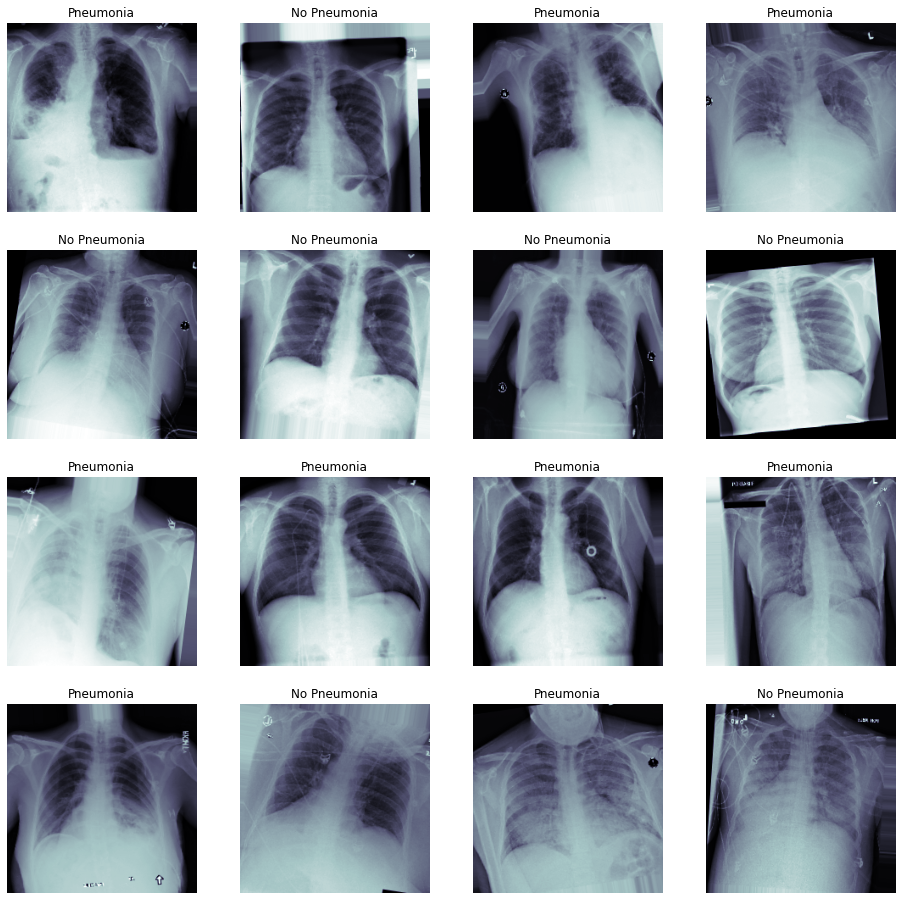

In [11]:
# Samples of our augmented training data. 

train_gen = make_train_gen(td)
print(type(train_gen))
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Model: 

In [12]:
def load_pretrained_model():

    model = VGG16(include_top=True, weights='imagenet')
    model.summary()
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)
    
    return vgg_model


In [13]:
def build_my_model(vargs):
    
    # Freezing the first 18 layers
    for layer in vargs.layers[0:17]:
        layer.trainable = False
    
    my_model = Sequential()

    my_model.add(vargs)
    my_model.add(Flatten())
    my_model.add(Dropout(0.35))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.35))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(0.35))
    my_model.add(Dense(64, activation='relu'))
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model


In [14]:

optimizer = Adam(lr=0.001)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
vgg = load_pretrained_model()
model = build_my_model(vgg)
model.summary()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


c:\Users\Grimm\Anaconda3\envs\machinelearning\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
# Adding checkpoints

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, period = 3, 
                             save_best_only=True, 
                             mode= 'auto', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'auto', 
                      patience=30)

callbacks_list = [checkpoint, early]

### Training. 

In [16]:
history = model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs =50, 
                          callbacks = callbacks_list)

c:\Users\Grimm\Anaconda3\envs\machinelearning\lib\site-packages\ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/50
72/72 [==============================] - 158s 2s/step - loss: 0.7765 - binary_accuracy: 0.4965 - val_loss: 0.6357 - val_binary_accuracy: 0.6250
Epoch 2/50
72/72 [==============================] - 81s 1s/step - loss: 0.6853 - binary_accuracy: 0.5498 - val_loss: 0.6612 - val_binary_accuracy: 0.5000
Epoch 3/50
72/72 [==============================] - ETA: 0s - loss: 0.6755 - binary_accuracy: 0.5878
Epoch 3: val_loss improved from inf to 0.65619, saving model to xray_class_my_model.best.hdf5
72/72 [==============================] - 78s 1s/step - loss: 0.6755 - binary_accuracy: 0.5878 - val_loss: 0.6562 - val_binary_accuracy: 0.6562
Epoch 4/50
72/72 [==============================] - 83s 1s/step - loss: 0.6673 - binary_accuracy: 0.6105 - val_loss: 0.6723 - val_binary_accuracy: 0.5625
Epoch 5/50
72/72 [==============================] - 77s 1s/step - loss: 0.6694 - binary_accuracy: 0.6004 - val_loss: 0.6301 - val_binary_accuracy: 0.7500
Epoch 6/50
72/72 [===========================

##### Performance:

In [17]:
## Predictions to test the model performance
pred_Y = model.predict(valX, batch_size = 32, verbose = True)

1/1 [==============================] - 1s 628ms/step


In [18]:
def plot_auc(t_y, p_y):
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
    
# Training history

def plot_history(history):
        
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    #plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    #plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

# Dynamic Choosing of F1
def choose_f1(pr,t_y,p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    clinic = pd.DataFrame()
    v = [0.2,0.3,0.4,0.5,0.6]
    clinic['Values'] = v
    idn=[]
    precs = []
    recs = []
    threshs = []
    f1s = []
    if (pr == True):
        p = precision
    else:
        p = recall
        
    for i in range(len(v)):
        value = v[i]
        idx = (np.abs(p - value)).argmin()
        prec = precision[idx]
        rec = recall[idx]
        thresh = thresholds[idx]
        f1 = calc_f1(precision[idx],recall[idx])
        
        idn.append(idx)
        precs.append(prec)
        recs.append(rec)
        threshs.append(thresh)
        f1s.append(f1)
        
    clinic['Idn'] = idn
    clinic['Precision'] = precs
    clinic['Recall'] = recs
    clinic['Threshold'] = threshs 
    clinic['F1'] = f1s
    return clinic
    

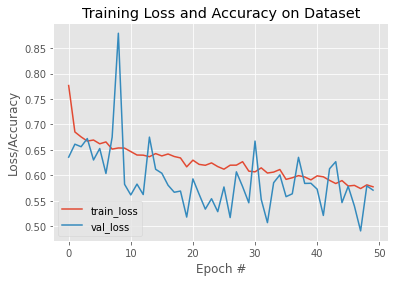

In [19]:
plot_history(history)

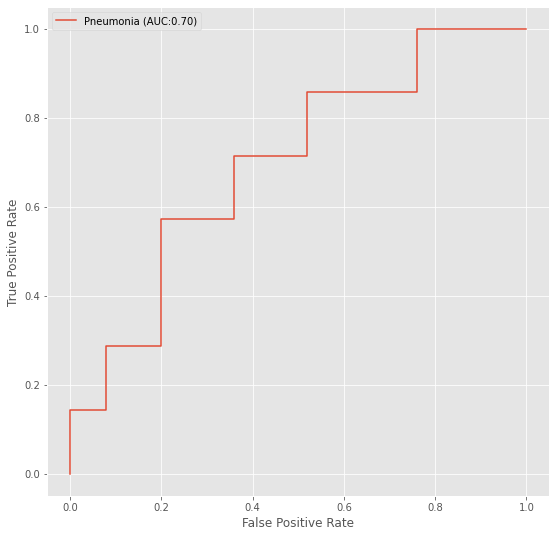

In [20]:
# plots

plot_auc(valY,pred_Y)


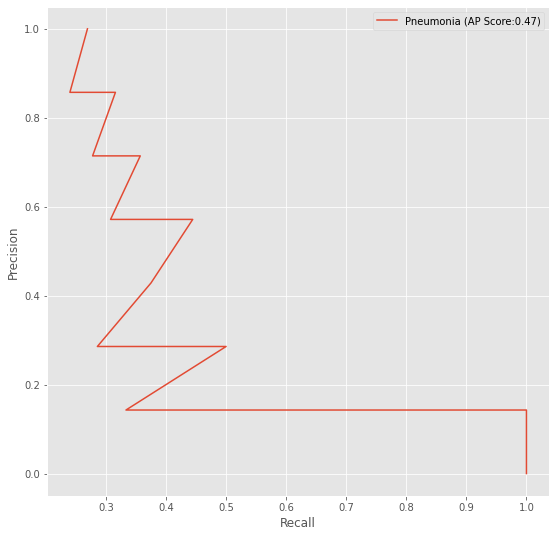

In [21]:
plot_pr(valY,pred_Y)

Optimization

In [22]:
rp = True  # Calculating Precision
clinicP = choose_f1(rp,valY,pred_Y)
print('Precision')
clinicP

Precision


,Values,Idn,Precision,Recall,Threshold,F1
0,0.2,1,0.24,0.857143,0.279725,0.375000
1,0.3,6,0.30,0.857143,0.362419,0.444444
2,0.4,16,0.40,0.571429,0.516269,0.470588
3,0.5,22,0.50,0.285714,0.627284,0.363636
4,0.6,22,0.50,0.285714,0.627284,0.363636


In [23]:
rp = False  # Calculating Recall
clinicR = choose_f1(rp,valY,pred_Y)
print('Recall')
clinicR

Recall


,Values,Idn,Precision,Recall,Threshold,F1
0,0.2,23,0.333333,0.142857,0.634812,0.200000
1,0.3,19,0.285714,0.285714,0.570795,0.285714
2,0.4,18,0.375000,0.428571,0.567528,0.400000
3,0.5,13,0.307692,0.571429,0.442853,0.400000
4,0.6,13,0.307692,0.571429,0.442853,0.400000


In [24]:
def maxF1(clinic):
    f1 = clinic['F1'].idxmax()
    print(f1)
    return f1

thresh = maxF1(clinicR)    

3


Threshold :  0.4428529441356659


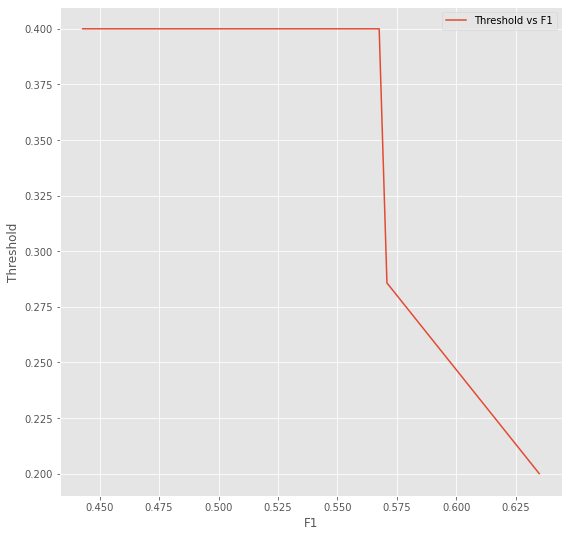

In [25]:
threshold = list(clinicR['Threshold'])
f1 = list(clinicR['F1'])

def plot_fvt(t,f):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    c_ax.plot(t, f, label='Threshold vs F1')
    c_ax.legend()
    c_ax.set_xlabel('F1')
    c_ax.set_ylabel('Threshold')
    
plot_fvt(threshold,f1)

print('Threshold : ',threshold[thresh])

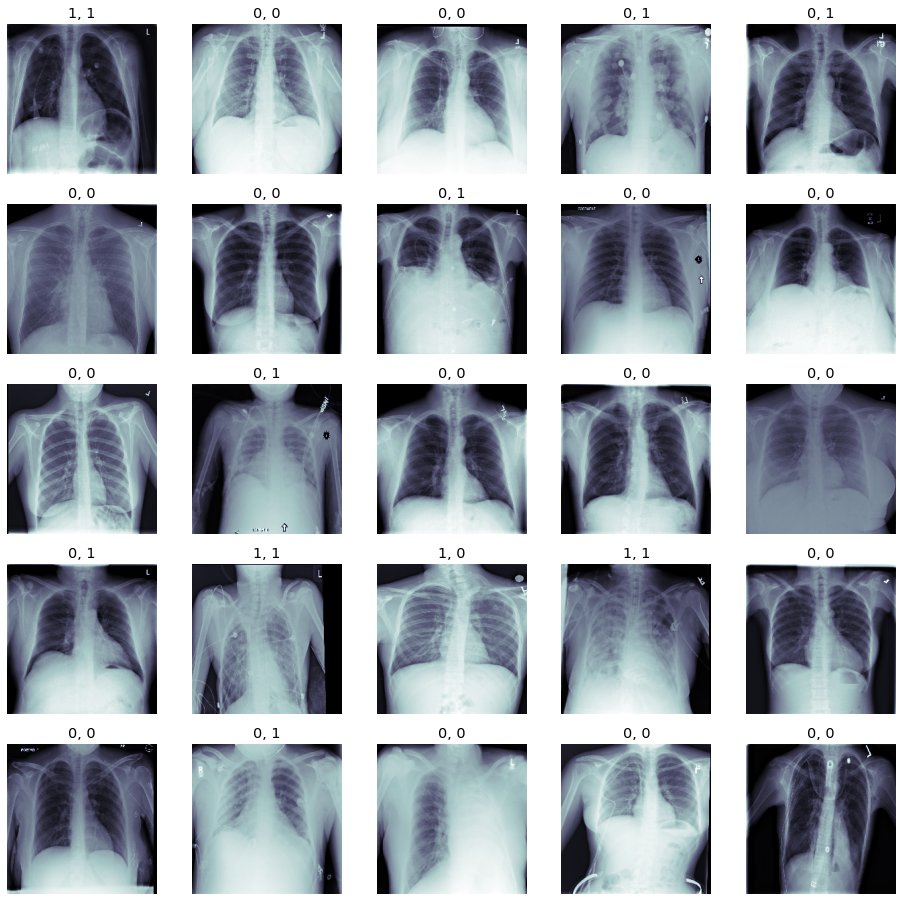

In [26]:
# Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(5, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold[thresh]:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold[thresh]: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [27]:
#Saving model to json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)